In [1]:
import query_helper
import pandas as pd 
import charlie_functions
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
query_helper.set_database_name('MLB_Stats')

In [3]:
games_teams = query_helper.query_to_df("""select G.gameid, G.home_team, t.team_name as away_team, G.game_date, G.status from 
(select g.gameid, g.game_date, g.status, t.team_name as home_team, g.away_id
from MLB_Stats.games g 
inner join MLB_Stats.teams t on t.team_id=g.home_id) G
inner join MLB_Stats.teams t on t.team_id=G.away_id;""")

In [4]:
#data.groupby(data.date.dt.year)
games_per_year = games_teams.groupby(games_teams.game_date.dt.year).count()['gameid']

In [5]:
games_per_year

game_date
2009    2394
2010    2408
2011    2380
2012    2409
2013    2392
2014    2390
2015    2389
2016    2404
2017    2392
2018    2379
2019    2388
Name: gameid, dtype: int64

In [6]:
runs_games = query_helper.query_to_df("""SELECT A.gameid, A.total_runs, t.league FROM 
(SELECT g.gameid, i.home_team_runs + i.away_team_runs as total_runs, g.home_id
from games g
inner join game_info i on i.gameid=g.gameid) A
inner join teams t on t.team_id=A.home_id;""")

In [7]:
NL = runs_games[runs_games['league']=='NL']
AL = runs_games[runs_games['league']=='AL']

In [8]:
contigency = pd.crosstab(runs_games['total_runs'],runs_games['league'])
contigency

league,AL,NL
total_runs,,
1,215,298
2,242,280
3,767,916
4,643,707
5,1225,1380
6,966,954
7,1459,1454
8,1016,1034
9,1367,1386


In [9]:
NL_runs = NL['total_runs']
AL_runs = AL['total_runs']

In [22]:
NL_runs.describe(), AL_runs.describe()

(count    13174.000000
 mean         8.612722
 std          4.413306
 min          1.000000
 25%          5.000000
 50%          8.000000
 75%         11.000000
 max         30.000000
 Name: total_runs, dtype: float64, count    13147.000000
 mean         9.012779
 std          4.467761
 min          1.000000
 25%          6.000000
 50%          9.000000
 75%         12.000000
 max         32.000000
 Name: total_runs, dtype: float64)

In [53]:
#two-sided, two-sample T-Test
#Null Hyp: means are equal
#Alt Hyp: means are not equal
stats.ttest_ind(AL_runs,NL_runs)

Ttest_indResult(statistic=7.3080541043893446, pvalue=2.78752559887634e-13)

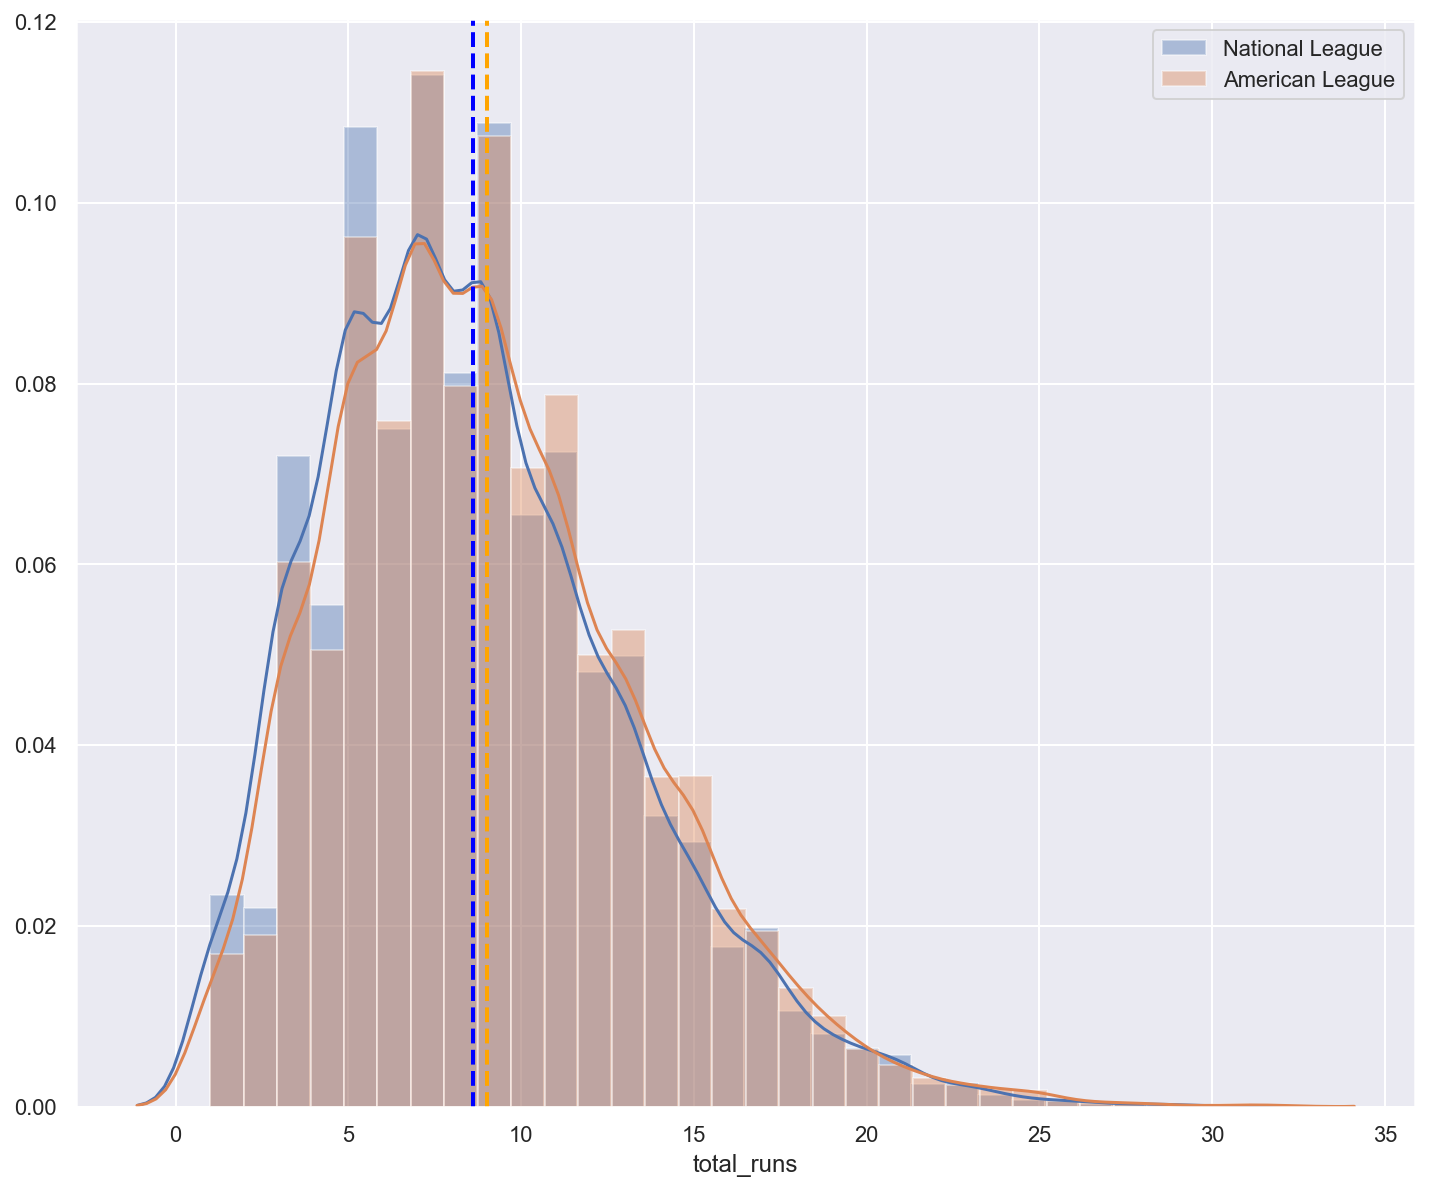

In [11]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})
sns.distplot(NL_runs,bins=NL_runs.max(),label='National League') # Blue distribution
sns.distplot(AL_runs,bins=AL_runs.max(),label='American League') # Green distribution
#plt.xticks(ticks=range(32))
plt.legend()
plt.axvline(NL_runs.mean(),color='blue', linestyle='--', lw=2)
plt.axvline(AL_runs.mean(),color='orange', linestyle='--', lw=2)

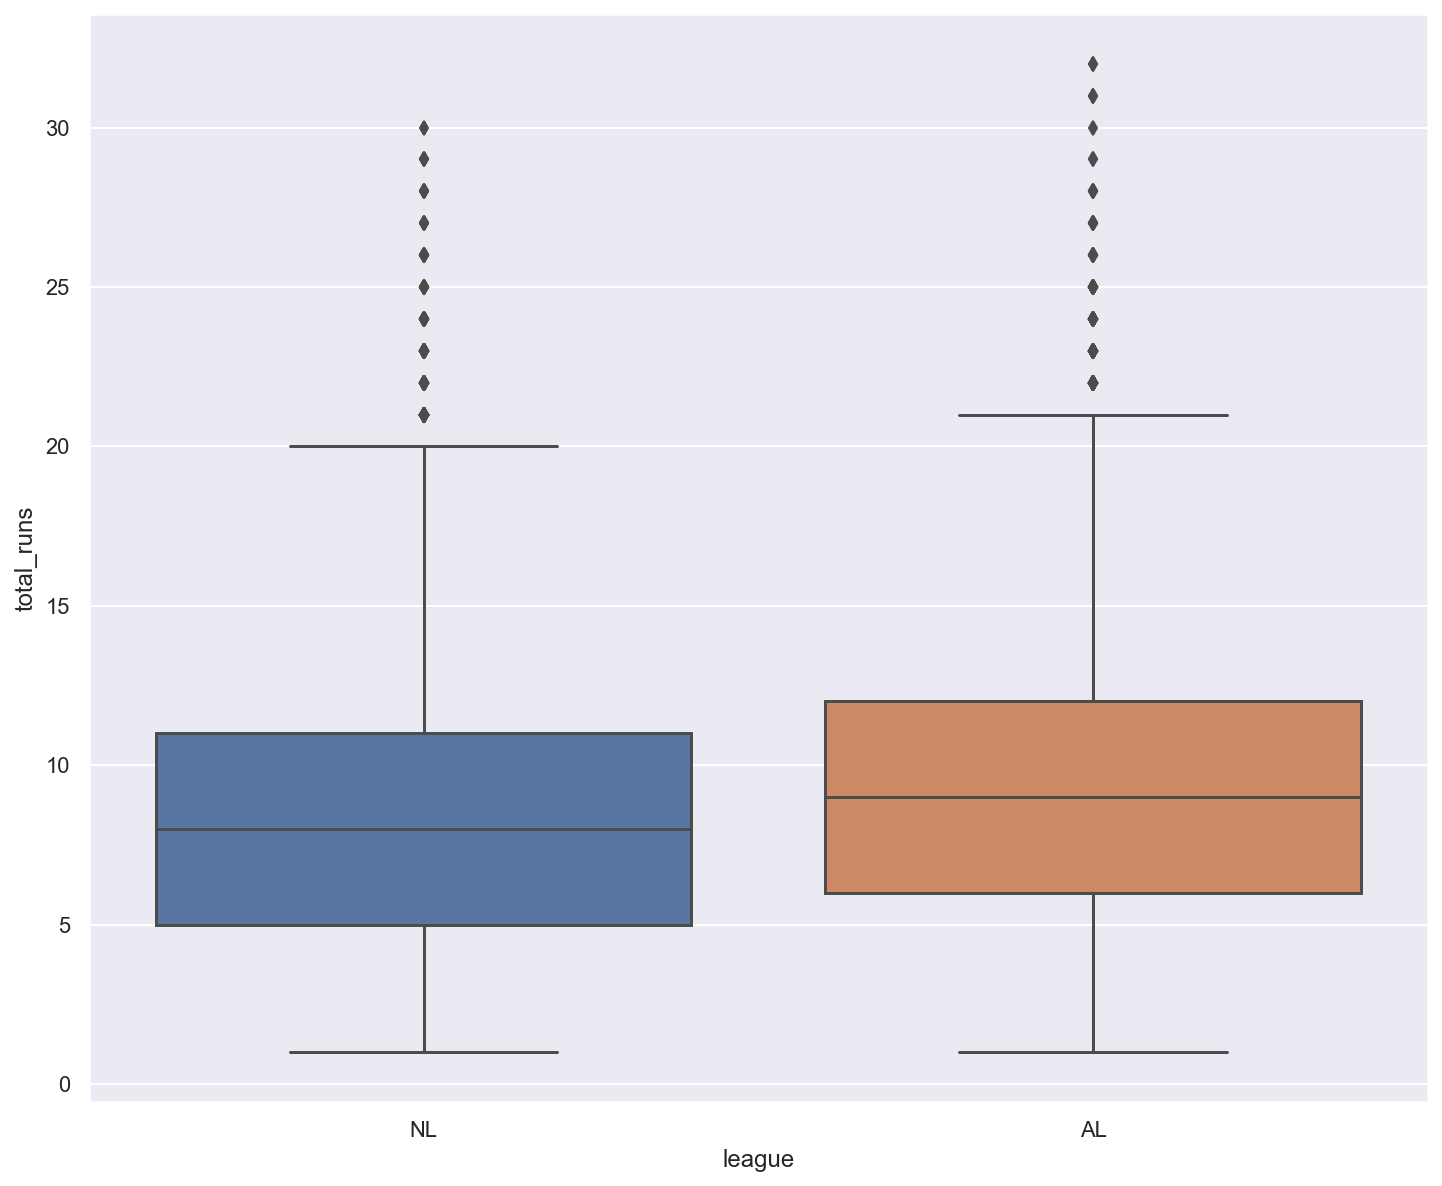

In [12]:
sns.boxplot(x=runs_games['league'],y=runs_games['total_runs'],orient='v')
#sns.boxplot(AL_runs,orient='v')

In [13]:
NL_samples = [np.random.choice(NL_runs, replace=False, size=30) for i in range(len(NL_runs/30))]
AL_samples = [np.random.choice(AL_runs, replace=False, size=30) for i in range(len(AL_runs/30))]

In [34]:
NL_sampleMeans = [np.mean(i) for i in NL_samples]
AL_sampleMeans = [np.mean(i) for i in AL_samples]

Text(0.5, 0, 'Mean Runs Scored per Game')

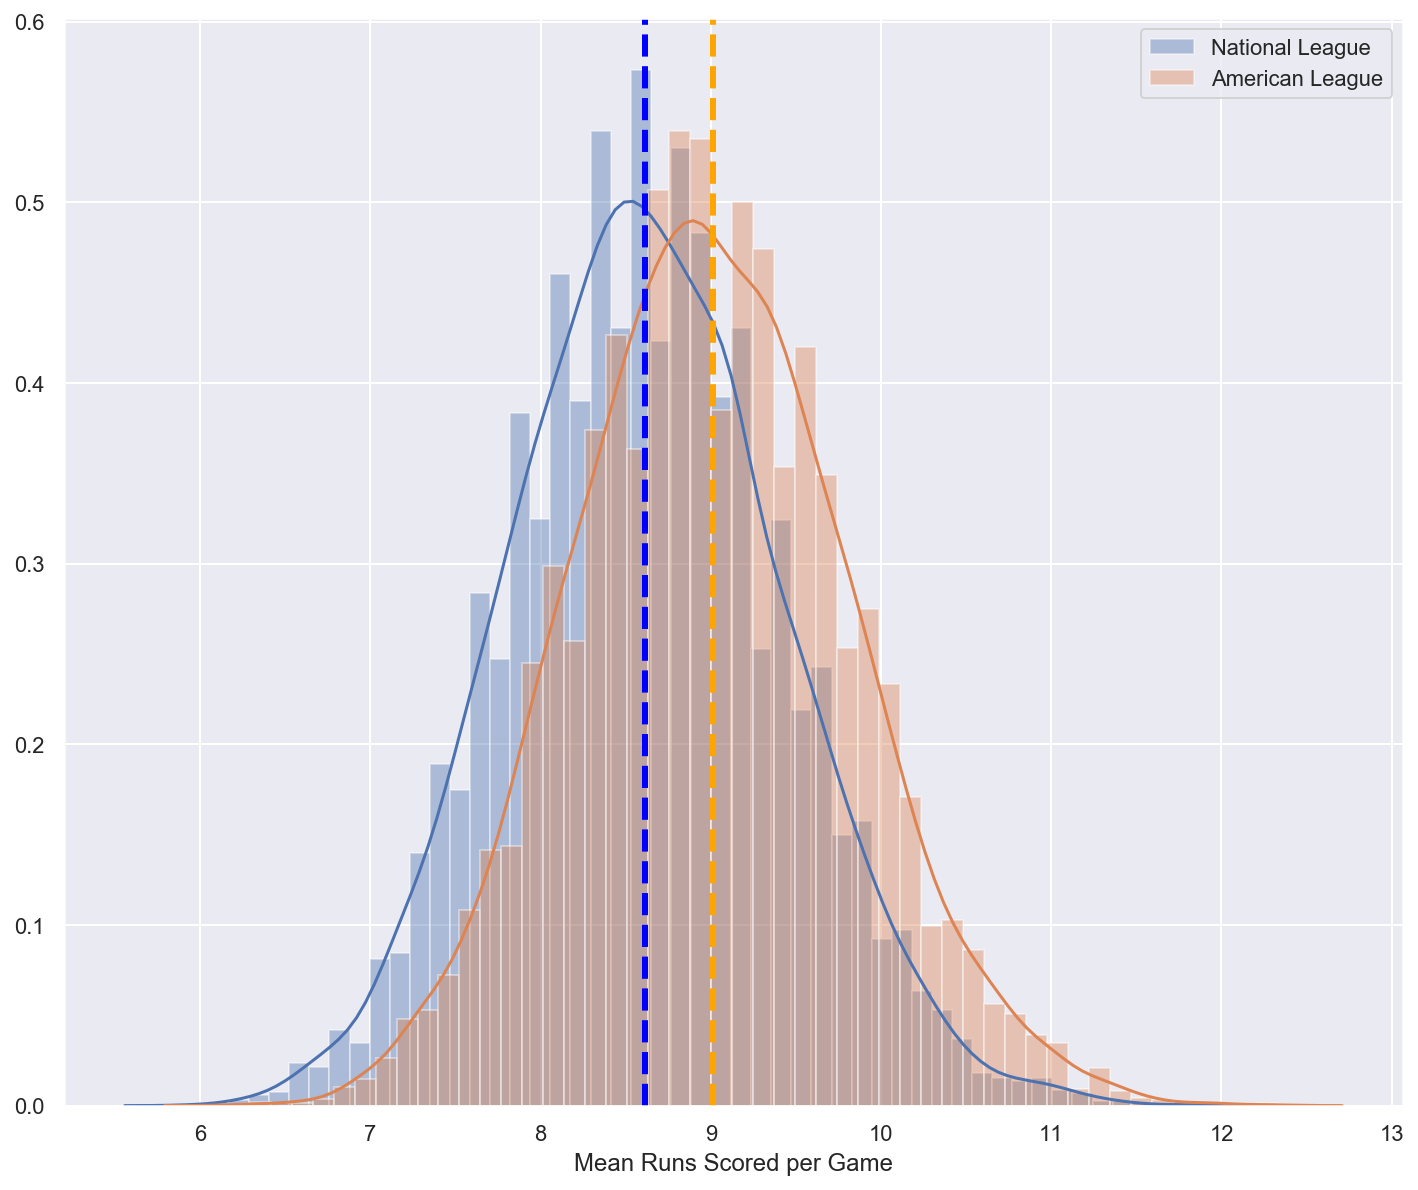

In [35]:
sns.distplot(NL_sampleMeans,label='National League')
sns.distplot(AL_sampleMeans,label='American League')
plt.axvline(NL_runs.mean(),color='blue', linestyle='--', lw=3)
plt.axvline(AL_runs.mean(),color='orange', linestyle='--', lw=3)
plt.legend()
plt.xlabel('Mean Runs Scored per Game')

In [54]:
AL_mean = np.mean(AL_runs)
NL_mean = np.mean(NL_runs)

NL_std = np.std(NL_runs)
AL_std = np.std(AL_runs)

NL_n = len(NL_runs)
AL_n = len(AL_runs)

numer = (AL_mean-NL_mean)
denom = np.sqrt((NL_std**2/NL_n)+(AL_std**2/AL_n))

print(numer,denom)

0.40005655242735294 0.05474047939554291


In [55]:
Z = numer/denom

In [56]:
Z

7.308239840879552

In [76]:
P_value = 1-stats.norm.cdf(Z)
alpha = .001
P_value < alpha

True

In [77]:
pooled_SD = np.sqrt((NL_std**2 + AL_std**2)/2)
cohens_d = (AL_mean - NL_mean)/pooled_SD
cohens_d

0.09009372728428088

- attempt to visualize our two-sample z test 

In [63]:
NL_Zscores = stats.zscore(NL_runs)
AL_Zscores = stats.zscore(AL_runs)

In [64]:
NL_Zscores

array([-0.81862869,  1.90052441, -0.81862869, ..., -0.36543651,
       -1.04522479, -0.36543651])

True

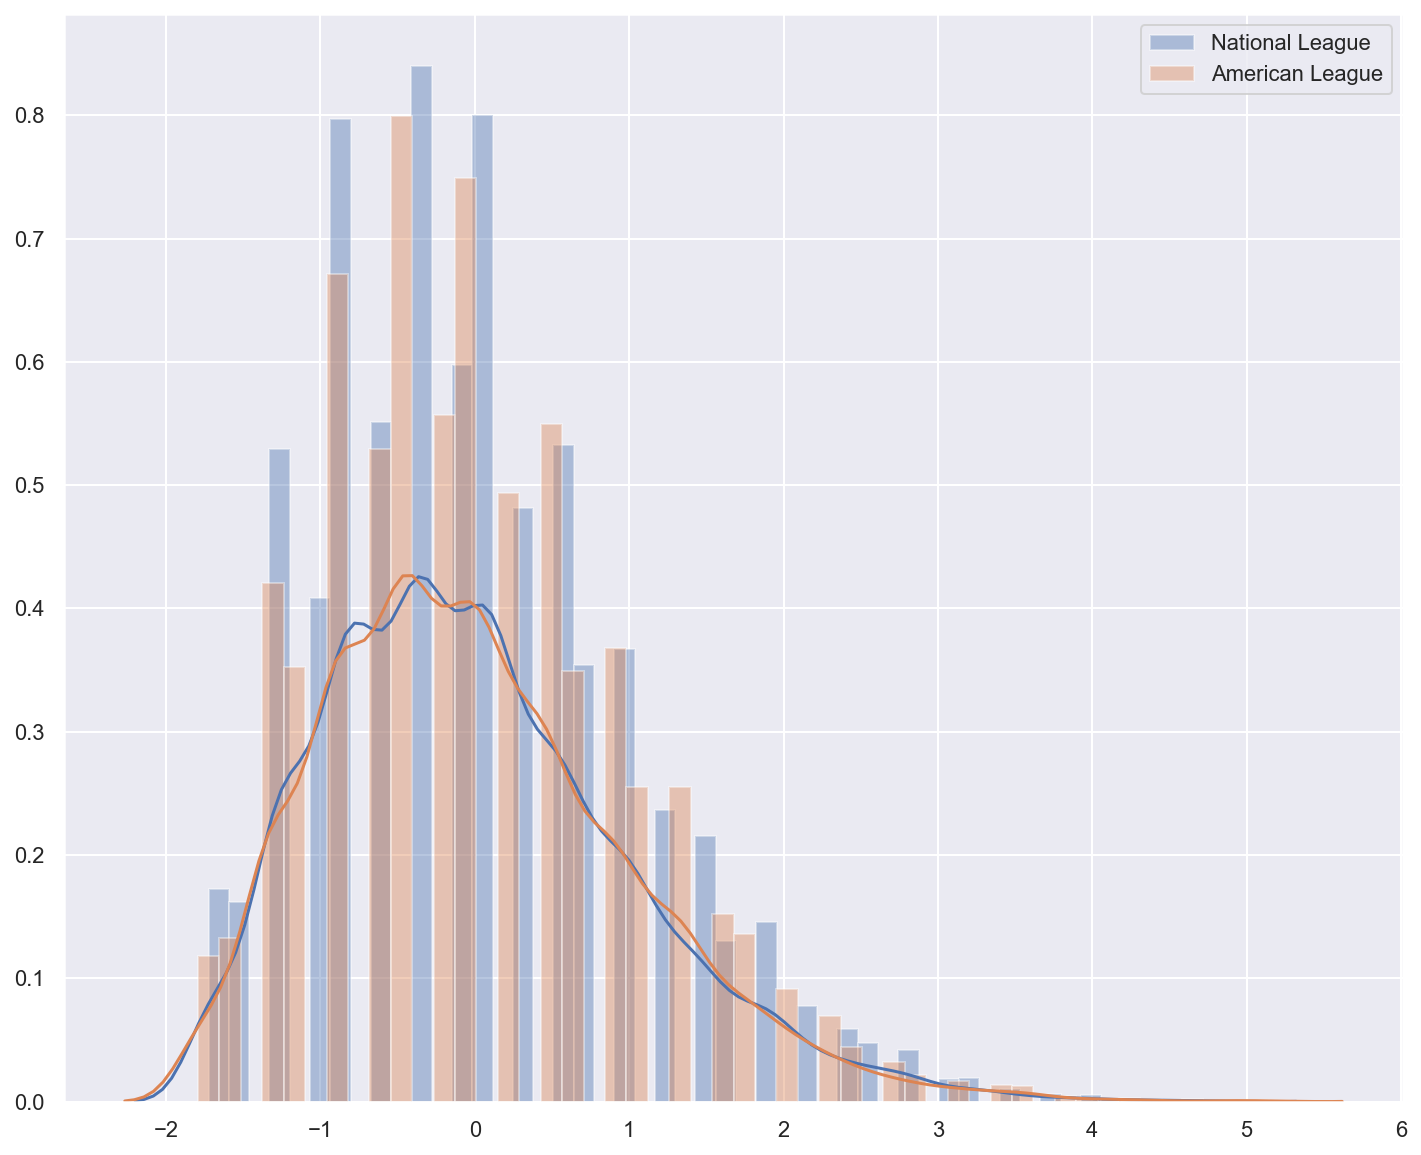

In [67]:
sns.distplot(NL_Zscores,label='National League')
sns.distplot(AL_Zscores,label='American League')
#plt.axvline(NL_runs.mean(),color='blue', linestyle='--', lw=3)
#plt.axvline(AL_runs.mean(),color='orange', linestyle='--', lw=3)
plt.legend()

In [104]:
NL_skew = stats.skew(NL_runs)
AL_skew = stats.skew(AL_runs)
print(NL_skew,AL_skew)

0.7606128171412102 0.7540337783692563


- moving on to weather 


In [79]:
df_weather = query_helper.query_to_df("""select 
i.home_team_runs + i.away_team_runs as total_runs, i.weather_category
from 
MLB_Stats.game_info i;""")

In [99]:
snow = df_weather[df_weather['weather_category']=='snow'].index
df_weather.drop(snow,inplace=True)

In [100]:
categories = list(df_weather['weather_category'].unique())
categories

['clear',
 'roof closed',
 'sunny',
 'overcast',
 'cloudy',
 'dome',
 'partly cloudy',
 'rain',
 'drizzle']

In [101]:
weather_dfs = [df_weather[df_weather['weather_category']==i] for i in categories]

In [102]:
weather_dfs[-1].head()

,total_runs,weather_category
190,5,drizzle
279,8,drizzle
368,13,drizzle
511,9,drizzle
520,15,drizzle


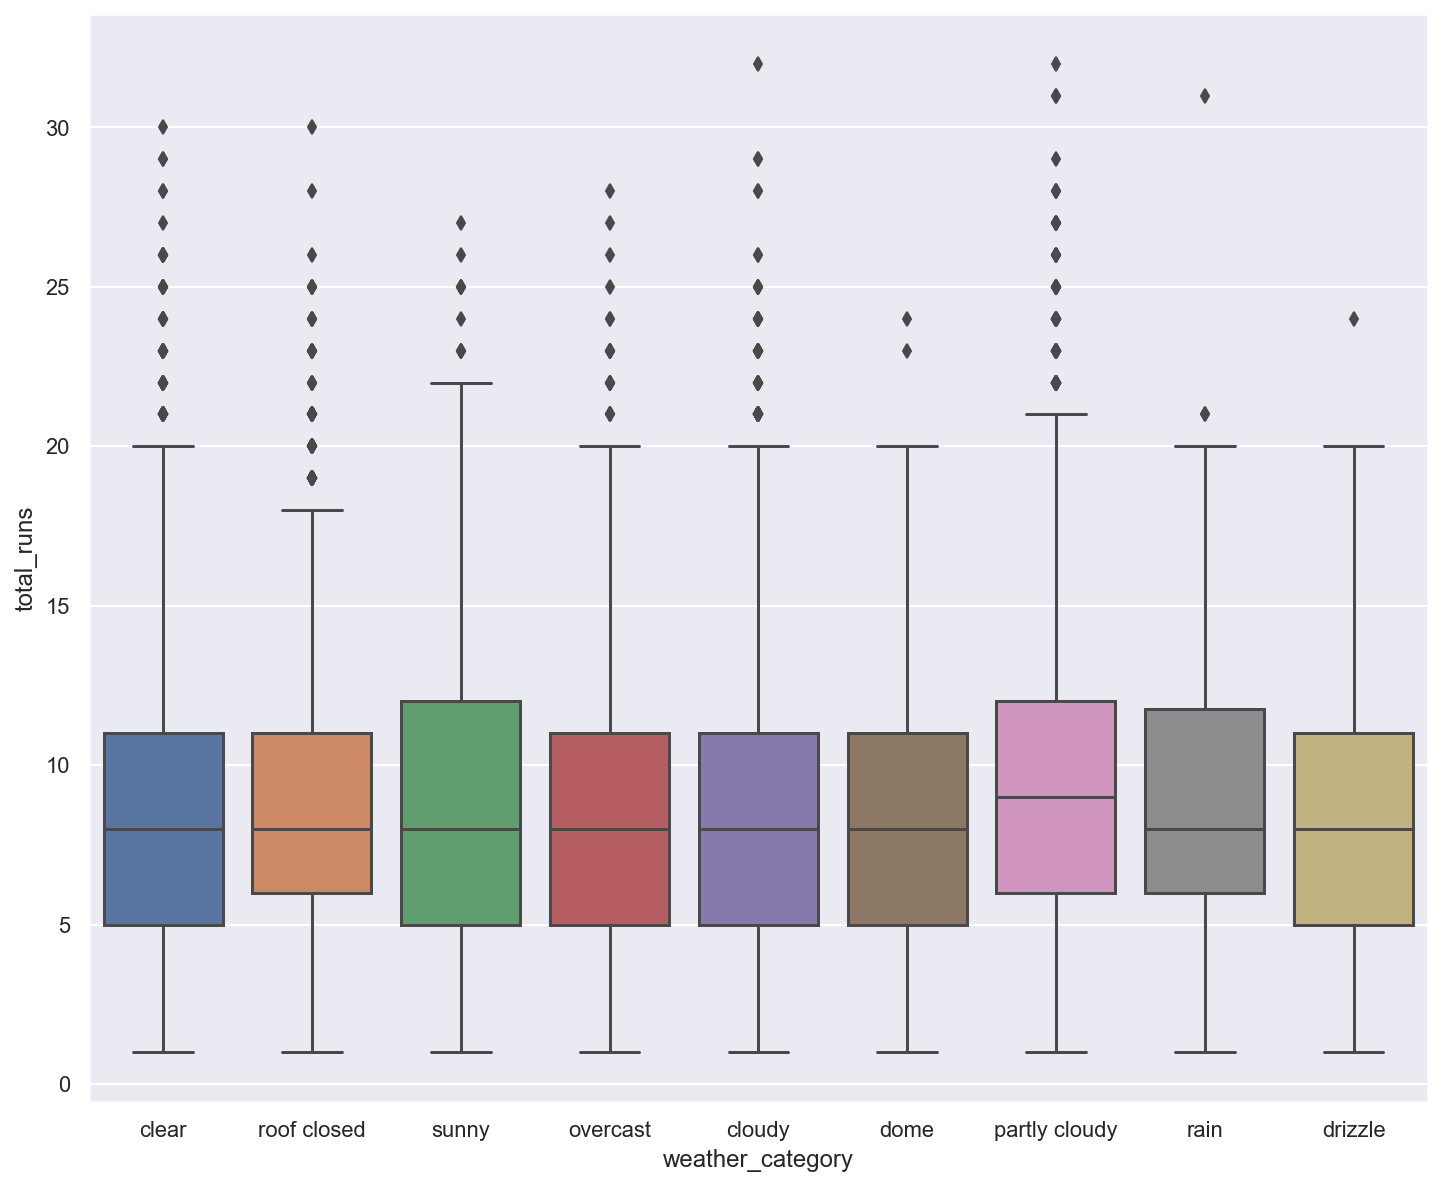

In [103]:
sns.boxplot(x=df_weather['weather_category'],y=df_weather['total_runs'],orient='v')

In [109]:
x = [(i,df_weather[df_weather['weather_category']==i].shape[0]) for i in categories]
x

[('clear', 5148),
 ('roof closed', 2711),
 ('sunny', 2580),
 ('overcast', 1573),
 ('cloudy', 4666),
 ('dome', 988),
 ('partly cloudy', 8324),
 ('rain', 142),
 ('drizzle', 187)]

In [106]:
df_weather[df_weather['weather_category']=='rain'].shape

(142, 2)

In [116]:
rainy = ['rain','drizzle']
df_rain = df_weather[df_weather.weather_category.isin(rainy)]
df_rain 

clear = ['clear','sunny']

,total_runs,weather_category
95,4,rain
190,5,drizzle
208,10,rain
279,8,drizzle
337,15,rain
...,...,...
25804,21,rain
25834,7,rain
25836,8,drizzle
25848,14,rain
